In [1]:
import requests
import pandas as pd 
import numpy as np
import re
import sys, getopt
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

def load_csv_dataset(file_path):
    return pd.read_csv(file_path)

os.chdir('/Users/finneganlaister-smith/Downloads/DEV ENVIRONMENT/data-science-jupyter-template-main/footy_project_market_value_rankings')

os.getcwd()

'/Users/finneganlaister-smith/Downloads/DEV ENVIRONMENT/data-science-jupyter-template-main/footy_project_market_value_rankings'

# VALUE

## The more valuable team winning

In [87]:
latest_match_data = load_csv_dataset('create_dataset_1/CSVs we use often/latest_match_data_june_18_SUPERSTAR_INFO_ADDED.csv')
latest_match_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
latest_match_data['mv_difference_abs'] = latest_match_data['Market.Value.Difference'].abs()
# Assuming 'latest_match_data' is already loaded
latest_match_data['MV_Prediction_Correct'] = np.where(
    (latest_match_data['Market.Value.Difference'] < 0) & (latest_match_data['Score.Difference'] < 0), 1,
    np.where(
        (latest_match_data['Market.Value.Difference'] > 0) & (latest_match_data['Score.Difference'] > 0), 1, 0
    )
)
pd.set_option('display.max_columns', None)

# ... existing code ...

# Define the intervals
intervals = [0, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000]
labels = ['0-500K', '500K-1M', '1M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-500M', '500M-1B']

# Create a new column for the intervals
latest_match_data['mv_interval'] = pd.cut(latest_match_data['mv_difference_abs'], bins=intervals, labels=labels)

# Group by the intervals and calculate the required statistics
interval_stats = latest_match_data.groupby('mv_interval').agg(
    total_games=('MV_Prediction_Correct', 'size'),
    more_valuable_wins=('MV_Prediction_Correct', 'sum')
).reset_index()

# Calculate the percentage of games won by the more valuable team
interval_stats['win_percentage'] = (interval_stats['more_valuable_wins'] / interval_stats['total_games']) * 100

# Display the results
interval_stats

/var/folders/vw/z2xv57_n70l_szw_fr80j5km0000gn/T/ipykernel_40664/1468209396.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interval_stats = latest_match_data.groupby('mv_interval').agg(


,mv_interval,total_games,more_valuable_wins,win_percentage
0,0-500K,244,106,43.442623
1,500K-1M,197,113,57.360406
2,1M-5M,654,373,57.033639
3,5M-10M,500,274,54.800000
4,10M-50M,1552,906,58.376289
5,50M-100M,820,512,62.439024
6,100M-500M,1255,898,71.553785
7,500M-1B,79,68,86.075949


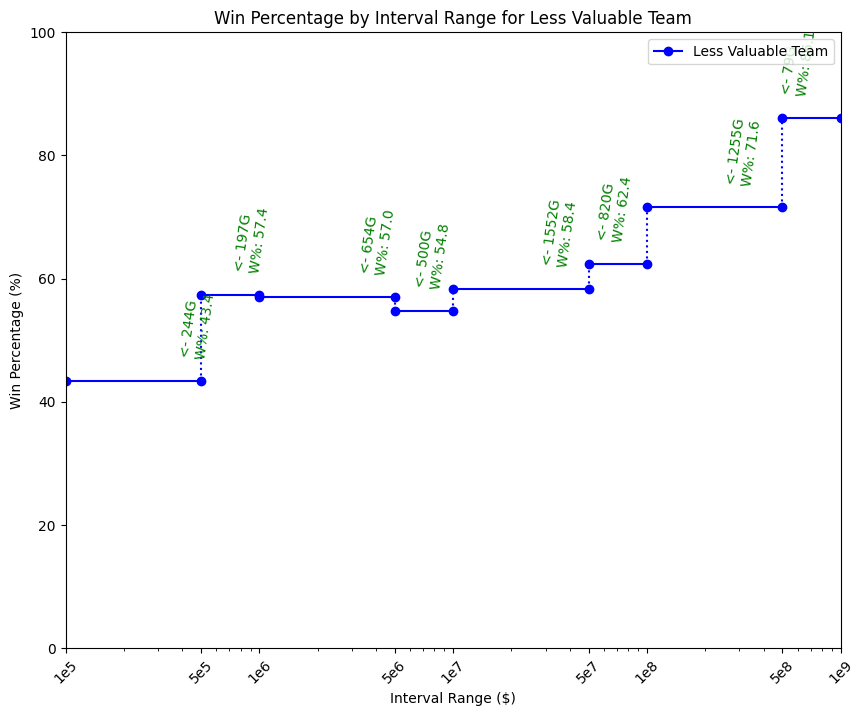

In [99]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function to display raw numbers
def custom_formatter(x, pos):
    if x == 1e5:
        return '1e5'
    elif x == 5e5:
        return '5e5'
    elif x == 1e6:
        return '1e6'
    elif x == 5e6:
        return '5e6'
    elif x == 1e7:
        return '1e7'
    elif x == 5e7:
        return '5e7'
    elif x == 1e8:
        return '1e8'
    elif x == 5e8:
        return '5e8'
    elif x == 1e9:
        return '1e9'
    else:
        return f'{x:.0e}'  # fallback for other values

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x-axis to a logarithmic scale and specify the range from 10^5 to 10^9
ax.set_xscale('log')
ax.set_xlim(1e5, 1e9)  # Set the range of x-axis from 10^5 to 10^9

# Define the intervals and their corresponding min and max values
intervals = {
    '0-500K': (1e5, 5e5),
    '500K-1M': (5e5, 1e6),
    '1M-5M': (1e6, 5e6),
    '5M-10M': (5e6, 1e7),
    '10M-50M': (1e7, 5e7),
    '50M-100M': (5e7, 1e8),
    '100M-500M': (1e8, 5e8),
    '500M-1B': (5e8, 1e9)
}

# Set custom ticks for the x-axis
ax.set_xticks([1e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9])
ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
ax.tick_params(axis='x', rotation=45)

# Set the y-axis range from 0 to 100
ax.set_ylim(0, 100)

# Initialize a variable to store the previous max interval value and win percentage
previous_max = None
previous_win_percentage = None

# Plot the line for the less valuable team
for _, row in interval_stats.iterrows():
    interval_min, interval_max = intervals[row['mv_interval']]
    
    # Plot horizontal line segment
    ax.plot([interval_min, interval_max], [row['win_percentage'], row['win_percentage']],
            label='Less Valuable Team' if previous_max is None else "",  # Label only the first segment to avoid duplicate legend entries
            color='blue', marker='o', linestyle='-')
    
    # If there's a previous segment, plot a vertical line connecting them
    if previous_max is not None and previous_win_percentage is not None:
        ax.vlines(x=previous_max, ymin=previous_win_percentage, ymax=row['win_percentage'], colors='blue', linestyles='dotted')
    
    # Update previous values
    previous_max = interval_max
    previous_win_percentage = row['win_percentage']

    # Add text label near the right end of the line only if the win percentage changes
    if previous_win_percentage is None or previous_win_percentage != row['win_percentage']:
        ax.text(interval_max, row['win_percentage'], f' Less Valuable Team', verticalalignment='center', color='blue')

    # Check if Total Matches equals 0 and add a pink vertical highlight over the entire range
    if row['total_games'] == 0:
        ax.axvspan(interval_min, interval_max, color='pink', alpha=0.5)  # Highlight the entire interval

    # Add text for non-zero total matches but zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] == 0:
        ax.text(interval_max, row['win_percentage'] - 5, f'<-- {row["total_games"]}G, 0W', verticalalignment='center', color='red')

    # Add text in green for non-zero total matches and non-zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] > 0:
        ax.text(interval_max*10 / np.log(interval_max), row['win_percentage'] + 9,  # Move left by 100000 and up by 5
                f'<- {row["total_games"]}G\nW%: {row["win_percentage"]:.1f}', 
                verticalalignment='center', color='green', rotation=82)

ax.set_xlabel('Interval Range ($)')
ax.set_ylabel('Win Percentage (%)')
ax.set_title('Win Percentage by Interval Range for Less Valuable Team')

# Display the legend
ax.legend()

plt.show()

## the less valuable team winning

In [66]:
latest_match_data = load_csv_dataset('create_dataset_1/CSVs we use often/latest_match_data_june_18_SUPERSTAR_INFO_ADDED.csv')
latest_match_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
latest_match_data['mv_difference_abs'] = latest_match_data['Market.Value.Difference'].abs()
# Assuming 'latest_match_data' is already loaded
latest_match_data['MV_Prediction_Correct_Inverted'] = np.where(
    (latest_match_data['Market.Value.Difference'] < 0) & (latest_match_data['Score.Difference'] > 0), 1,
    np.where(
        (latest_match_data['Market.Value.Difference'] > 0) & (latest_match_data['Score.Difference'] < 0), 1, 0
    )
)
pd.set_option('display.max_columns', None)

In [67]:
# ... existing code ...

# Define the intervals
intervals = [0, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000]
labels = ['0-500K', '500K-1M', '1M-5M', '5M-10M', '10M-50M', '50M-100M', '100M-500M', '500M-1B']

# Create a new column for the intervals
latest_match_data['mv_interval'] = pd.cut(latest_match_data['mv_difference_abs'], bins=intervals, labels=labels)

# Group by the intervals and calculate the required statistics
interval_stats = latest_match_data.groupby('mv_interval').agg(
    total_games=('MV_Prediction_Correct_Inverted', 'size'),
    less_valuable_wins=('MV_Prediction_Correct_Inverted', 'sum')
).reset_index()

# Calculate the percentage of games won by the less valuable team
interval_stats['win_percentage'] = (interval_stats['less_valuable_wins'] / interval_stats['total_games']) * 100

# Display the results
interval_stats

/var/folders/vw/z2xv57_n70l_szw_fr80j5km0000gn/T/ipykernel_40664/3587845510.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interval_stats = latest_match_data.groupby('mv_interval').agg(


,mv_interval,total_games,less_valuable_wins,win_percentage
0,0-500K,244,84,34.426230
1,500K-1M,197,41,20.812183
2,1M-5M,654,135,20.642202
3,5M-10M,500,105,21.000000
4,10M-50M,1552,284,18.298969
5,50M-100M,820,135,16.463415
6,100M-500M,1255,129,10.278884
7,500M-1B,79,4,5.063291


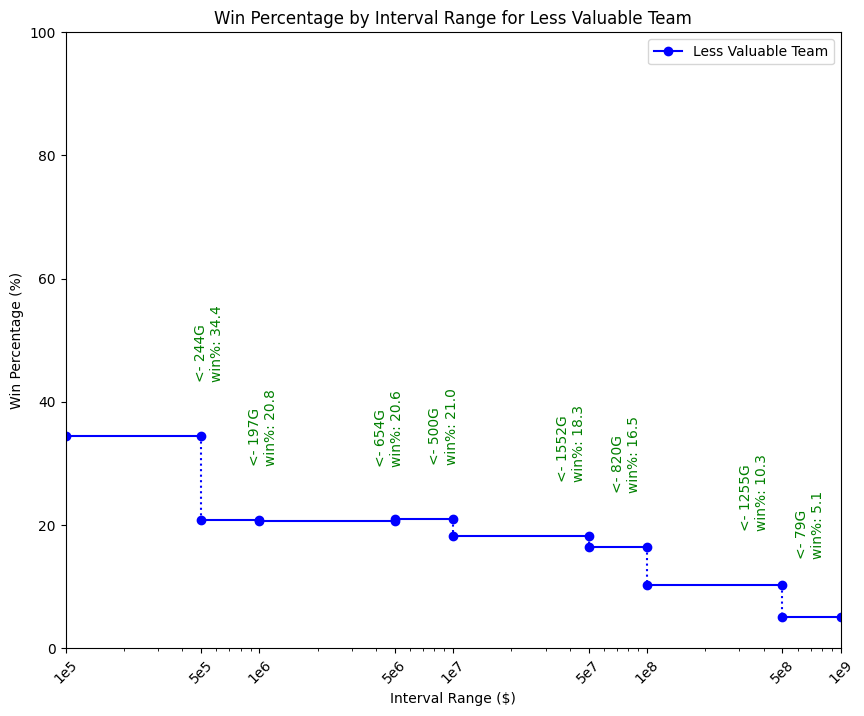

In [85]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function to display raw numbers
def custom_formatter(x, pos):
    if x == 1e5:
        return '1e5'
    elif x == 5e5:
        return '5e5'
    elif x == 1e6:
        return '1e6'
    elif x == 5e6:
        return '5e6'
    elif x == 1e7:
        return '1e7'
    elif x == 5e7:
        return '5e7'
    elif x == 1e8:
        return '1e8'
    elif x == 5e8:
        return '5e8'
    elif x == 1e9:
        return '1e9'
    else:
        return f'{x:.0e}'  # fallback for other values

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x-axis to a logarithmic scale and specify the range from 10^5 to 10^9
ax.set_xscale('log')
ax.set_xlim(1e5, 1e9)  # Set the range of x-axis from 10^5 to 10^9

# Define the intervals and their corresponding min and max values
intervals = {
    '0-500K': (1e5, 5e5),
    '500K-1M': (5e5, 1e6),
    '1M-5M': (1e6, 5e6),
    '5M-10M': (5e6, 1e7),
    '10M-50M': (1e7, 5e7),
    '50M-100M': (5e7, 1e8),
    '100M-500M': (1e8, 5e8),
    '500M-1B': (5e8, 1e9)
}

# Set custom ticks for the x-axis
ax.set_xticks([1e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9])
ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
ax.tick_params(axis='x', rotation=45)

# Set the y-axis range from 0 to 100
ax.set_ylim(0, 100)

# Initialize a variable to store the previous max interval value and win percentage
previous_max = None
previous_win_percentage = None

# Plot the line for the less valuable team
for _, row in interval_stats.iterrows():
    interval_min, interval_max = intervals[row['mv_interval']]
    
    # Plot horizontal line segment
    ax.plot([interval_min, interval_max], [row['win_percentage'], row['win_percentage']],
            label='Less Valuable Team' if previous_max is None else "",  # Label only the first segment to avoid duplicate legend entries
            color='blue', marker='o', linestyle='-')
    
    # If there's a previous segment, plot a vertical line connecting them
    if previous_max is not None and previous_win_percentage is not None:
        ax.vlines(x=previous_max, ymin=previous_win_percentage, ymax=row['win_percentage'], colors='blue', linestyles='dotted')
    
    # Update previous values
    previous_max = interval_max
    previous_win_percentage = row['win_percentage']

    # Add text label near the right end of the line only if the win percentage changes
    if previous_win_percentage is None or previous_win_percentage != row['win_percentage']:
        ax.text(interval_max, row['win_percentage'], f' Less Valuable Team', verticalalignment='center', color='blue')

    # Check if Total Matches equals 0 and add a pink vertical highlight over the entire range
    if row['total_games'] == 0:
        ax.axvspan(interval_min, interval_max, color='pink', alpha=0.5)  # Highlight the entire interval

    # Add text for non-zero total matches but zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] == 0:
        ax.text(interval_max, row['win_percentage'] - .2, f'{row["total_games"]}G, 0W', verticalalignment='center', color='red')

    # Add text in green for non-zero total matches and non-zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] > 0:
        ax.text(interval_max * 12 / np.log(interval_max), row['win_percentage'] + 15,  # Adjust the value 50000 as needed
                f'<- {row["total_games"]}G\nwin%: {row["win_percentage"]:.1f}', 
                verticalalignment='center', color='green', rotation=90)

ax.set_xlabel('Interval Range ($)')
ax.set_ylabel('Win Percentage (%)')
ax.set_title('Win Percentage by Interval Range for Less Valuable Team')

# Display the legend
ax.legend()

plt.show()

# RANKING

## The lower ranked team winning

In [107]:
latest_match_data = load_csv_dataset('create_dataset_1/CSVs we use often/latest_match_data_june_18_SUPERSTAR_INFO_ADDED.csv')
latest_match_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
latest_match_data['rank_difference_abs'] = latest_match_data['Rank.Difference'].abs()
# Assuming 'latest_match_data' is already loaded
latest_match_data['Rank_Prediction_Correct'] = np.where(
    (latest_match_data['Rank.Difference'] > 0) & (latest_match_data['Score.Difference'] > 0), 1,
    np.where(
        (latest_match_data['Rank.Difference'] < 0) & (latest_match_data['Score.Difference'] < 0), 1, 0
    )
)
pd.set_option('display.max_columns', None)

#// ... existing code ...

# Define the intervals
intervals = [0, 30, 60, 90, 120, 150, 180, 210]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180-210']

# Create a new column for the intervals
latest_match_data['rank_interval'] = pd.cut(latest_match_data['rank_difference_abs'], bins=intervals, labels=labels)

# Group by the intervals and calculate the required statistics
interval_stats = latest_match_data.groupby('rank_interval').agg(
    total_games=('Rank_Prediction_Correct', 'size'),
    higher_ranked_wins=('Rank_Prediction_Correct', 'sum')
).reset_index()

# Calculate the percentage of games won by the higher ranked team
interval_stats['win_percentage'] = (interval_stats['higher_ranked_wins'] / interval_stats['total_games']) * 100

# Display the results
interval_stats

/var/folders/vw/z2xv57_n70l_szw_fr80j5km0000gn/T/ipykernel_40664/888999580.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interval_stats = latest_match_data.groupby('rank_interval').agg(


,rank_interval,total_games,higher_ranked_wins,win_percentage
0,0-30,2168,1038,47.878229
1,30-60,1484,881,59.366577
2,60-90,874,606,69.336384
3,90-120,440,356,80.909091
4,120-150,210,189,90.000000
5,150-180,96,94,97.916667
6,180-210,42,42,100.000000


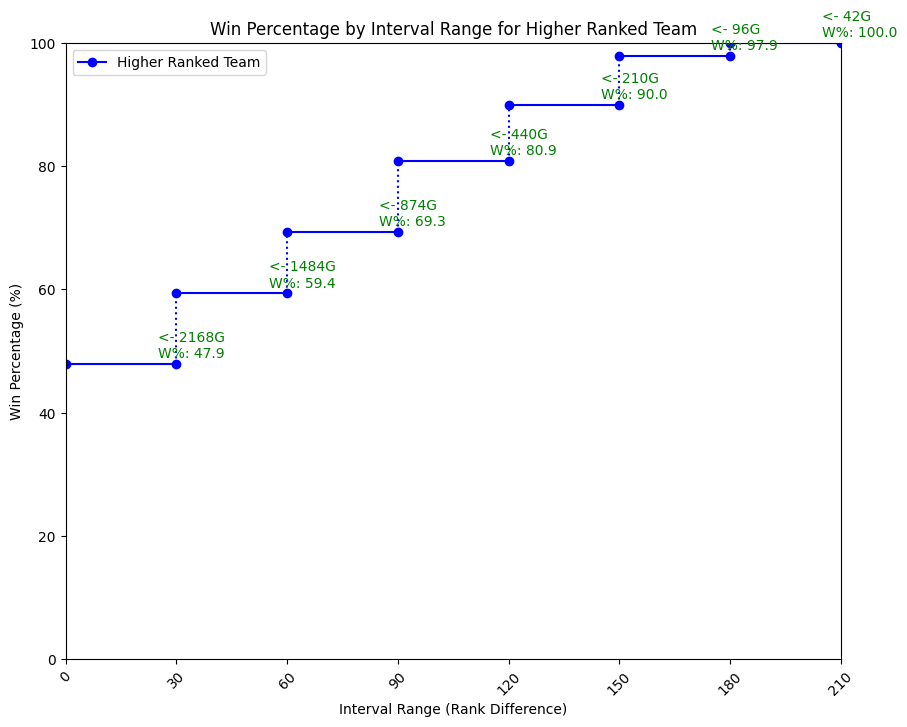

In [113]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function to display raw numbers
def custom_formatter(x, pos):
    return f'{int(x)}'  # Display as integer

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x-axis to a linear scale and specify the range from 0 to 210
ax.set_xlim(0, 210)  # Set the range of x-axis from 0 to 210

# Define the intervals and their corresponding min and max values
intervals = {
    '0-30': (0, 30),
    '30-60': (30, 60),
    '60-90': (60, 90),
    '90-120': (90, 120),
    '120-150': (120, 150),
    '150-180': (150, 180),
    '180-210': (180, 210)
}

# Set custom ticks for the x-axis
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210])
ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
ax.tick_params(axis='x', rotation=45)

# Set the y-axis range from 0 to 100
ax.set_ylim(0, 100)

# Initialize a variable to store the previous max interval value and win percentage
previous_max = None
previous_win_percentage = None

# Plot the line for the higher ranked team
for _, row in interval_stats.iterrows():
    interval_min, interval_max = intervals[row['rank_interval']]
    
    # Plot horizontal line segment
    ax.plot([interval_min, interval_max], [row['win_percentage'], row['win_percentage']],
            label='Higher Ranked Team' if previous_max is None else "",  # Label only the first segment to avoid duplicate legend entries
            color='blue', marker='o', linestyle='-')
    
    # If there's a previous segment, plot a vertical line connecting them
    if previous_max is not None and previous_win_percentage is not None:
        ax.vlines(x=previous_max, ymin=previous_win_percentage, ymax=row['win_percentage'], colors='blue', linestyles='dotted')
    
    # Update previous values
    previous_max = interval_max
    previous_win_percentage = row['win_percentage']

    # Add text label near the right end of the line only if the win percentage changes
    if previous_win_percentage is None or previous_win_percentage != row['win_percentage']:
        ax.text(interval_max, row['win_percentage'], f' Higher Ranked Team', verticalalignment='center', color='blue')

    # Check if Total Matches equals 0 and add a pink vertical highlight over the entire range
    if row['total_games'] == 0:
        ax.axvspan(interval_min, interval_max, color='pink', alpha=0.5)  # Highlight the entire interval

    # Add text for non-zero total matches but zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] == 0:
        ax.text(interval_max, row['win_percentage'] - 5, f'<-- {row["total_games"]}G, 0W', verticalalignment='center', color='red')

    # Add text in green for non-zero total matches and non-zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] > 0:
        ax.text(interval_max - 5, row['win_percentage'] + 3,  # Adjust the position as needed
                f'<- {row["total_games"]}G\nW%: {row["win_percentage"]:.1f}', 
                verticalalignment='center', color='green', rotation=0)

ax.set_xlabel('Interval Range (Rank Difference)')
ax.set_ylabel('Win Percentage (%)')
ax.set_title('Win Percentage by Interval Range for Higher Ranked Team')

# Display the legend
ax.legend()

plt.show()

## The higher ranked team winning

In [115]:
latest_match_data = load_csv_dataset('create_dataset_1/CSVs we use often/latest_match_data_june_18_SUPERSTAR_INFO_ADDED.csv')
latest_match_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
latest_match_data['rank_difference_abs'] = latest_match_data['Rank.Difference'].abs()
# Assuming 'latest_match_data' is already loaded
latest_match_data['Rank_Prediction_Correct'] = np.where(
    (latest_match_data['Rank.Difference'] < 0) & (latest_match_data['Score.Difference'] > 0), 1,
    np.where(
        (latest_match_data['Rank.Difference'] > 0) & (latest_match_data['Score.Difference'] < 0), 1, 0
    )
)
pd.set_option('display.max_columns', None)

#// ... existing code ...

# Define the intervals
intervals = [0, 30, 60, 90, 120, 150, 180, 210]
labels = ['0-30', '30-60', '60-90', '90-120', '120-150', '150-180', '180-210']

# Create a new column for the intervals
latest_match_data['rank_interval'] = pd.cut(latest_match_data['rank_difference_abs'], bins=intervals, labels=labels)

# Group by the intervals and calculate the required statistics
interval_stats = latest_match_data.groupby('rank_interval').agg(
    total_games=('Rank_Prediction_Correct', 'size'),
    higher_ranked_wins=('Rank_Prediction_Correct', 'sum')
).reset_index()

# Calculate the percentage of games won by the higher ranked team
interval_stats['win_percentage'] = (interval_stats['higher_ranked_wins'] / interval_stats['total_games']) * 100

# Display the results
interval_stats

/var/folders/vw/z2xv57_n70l_szw_fr80j5km0000gn/T/ipykernel_40664/2563052803.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interval_stats = latest_match_data.groupby('rank_interval').agg(


,rank_interval,total_games,higher_ranked_wins,win_percentage
0,0-30,2168,581,26.798893
1,30-60,1484,260,17.520216
2,60-90,874,98,11.212815
3,90-120,440,25,5.681818
4,120-150,210,5,2.380952
5,150-180,96,2,2.083333
6,180-210,42,0,0.000000


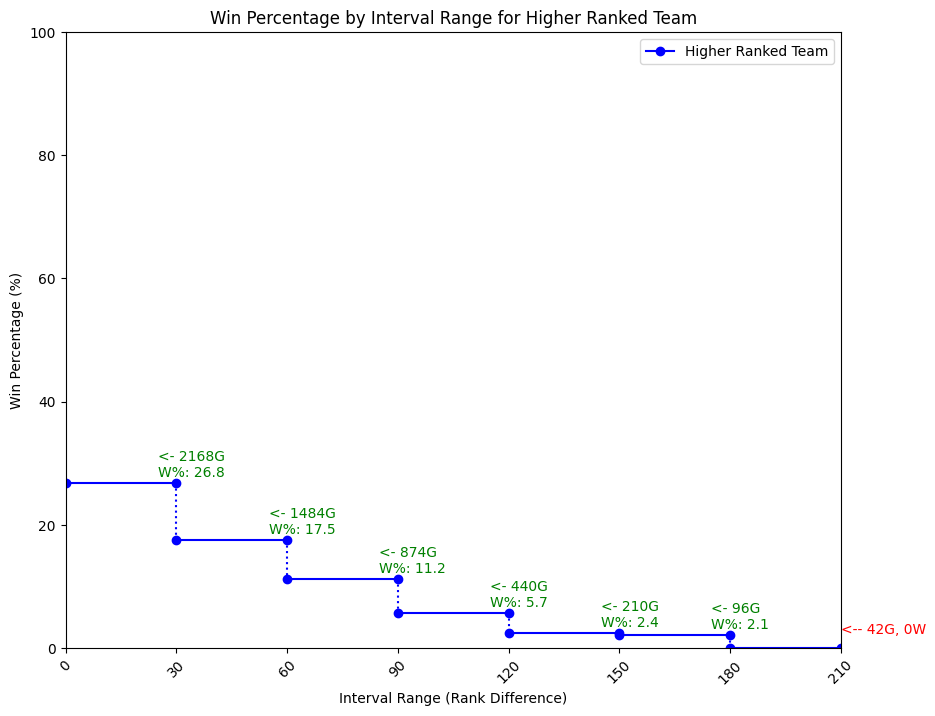

In [117]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function to display raw numbers
def custom_formatter(x, pos):
    return f'{int(x)}'  # Display as integer

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Set the x-axis to a linear scale and specify the range from 0 to 210
ax.set_xlim(0, 210)  # Set the range of x-axis from 0 to 210

# Define the intervals and their corresponding min and max values
intervals = {
    '0-30': (0, 30),
    '30-60': (30, 60),
    '60-90': (60, 90),
    '90-120': (90, 120),
    '120-150': (120, 150),
    '150-180': (150, 180),
    '180-210': (180, 210)
}

# Set custom ticks for the x-axis
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210])
ax.get_xaxis().set_major_formatter(FuncFormatter(custom_formatter))
ax.tick_params(axis='x', rotation=45)

# Set the y-axis range from 0 to 100
ax.set_ylim(0, 100)

# Initialize a variable to store the previous max interval value and win percentage
previous_max = None
previous_win_percentage = None

# Plot the line for the higher ranked team
for _, row in interval_stats.iterrows():
    interval_min, interval_max = intervals[row['rank_interval']]
    
    # Plot horizontal line segment
    ax.plot([interval_min, interval_max], [row['win_percentage'], row['win_percentage']],
            label='Higher Ranked Team' if previous_max is None else "",  # Label only the first segment to avoid duplicate legend entries
            color='blue', marker='o', linestyle='-')
    
    # If there's a previous segment, plot a vertical line connecting them
    if previous_max is not None and previous_win_percentage is not None:
        ax.vlines(x=previous_max, ymin=previous_win_percentage, ymax=row['win_percentage'], colors='blue', linestyles='dotted')
    
    # Update previous values
    previous_max = interval_max
    previous_win_percentage = row['win_percentage']

    # Add text label near the right end of the line only if the win percentage changes
    if previous_win_percentage is None or previous_win_percentage != row['win_percentage']:
        ax.text(interval_max, row['win_percentage'], f' Higher Ranked Team', verticalalignment='center', color='blue')

    # Check if Total Matches equals 0 and add a pink vertical highlight over the entire range
    if row['total_games'] == 0:
        ax.axvspan(interval_min, interval_max, color='pink', alpha=0.5)  # Highlight the entire interval

    # Add text for non-zero total matches but zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] == 0:
        ax.text(interval_max, row['win_percentage'] + 3, f'<-- {row["total_games"]}G, 0W', verticalalignment='center', color='red')

    # Add text in green for non-zero total matches and non-zero win percentage
    if row['total_games'] > 0 and row['win_percentage'] > 0:
        ax.text(interval_max - 5, row['win_percentage'] + 3,  # Adjust the position as needed
                f'<- {row["total_games"]}G\nW%: {row["win_percentage"]:.1f}', 
                verticalalignment='center', color='green', rotation=0)

ax.set_xlabel('Interval Range (Rank Difference)')
ax.set_ylabel('Win Percentage (%)')
ax.set_title('Win Percentage by Interval Range for Higher Ranked Team')

# Display the legend
ax.legend()

plt.show()